# Hypothesis Testing

## Getting Started
### Libraries to Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats

### Read in Data

This is a fairly common dataset, here sourced from [data.world](https://data.world/data-society/capital-bikeshare-2011-2012), but also available from the UCI database.

In [2]:
df = pd.read_csv('Data/bike_data.csv')

## Data Cleaning

Our date column was an object, so transform to a datetime with pandas and create a new column for Month.

In [3]:
df.Date = pd.to_datetime(arg=df.Date) #dtype('<M8[ns]')
df['Month'] = df['Date'].dt.month

In [4]:
df.sample(5)

,Date,Season,Hour,Holiday,Day of the Week,Working Day,Weather Type,Temperature F,Temperature Feels F,Humidity,Wind Speed,Casual Users,Registered Users,Total Users,Month
10529,2012-03-19,1,20,0,1,1,1,67.7,75.2,64,15,34,296,330,3
6865,2011-10-18,3,15,0,2,1,1,69.4,77.0,50,13,66,139,205,10
11404,2012-04-25,1,9,0,3,1,1,52.1,53.6,54,0,33,288,321,4
4897,2011-07-27,2,23,0,3,1,1,79.8,82.4,45,6,16,93,109,7
4067,2011-06-23,2,9,0,4,1,2,79.8,86.0,70,9,33,194,227,6


## Hypothesis Testing

### Do users ride more during comfortable temperatures?

Thanks to Matt Wilkins for his bike riding expertise. 

In [5]:
df['Comfortable Temp?'] = np.where((df['Temperature Feels F'] > 50) & (df['Temperature Feels F'] < 85), 1, 0)

#### Let's Start with some Visualization

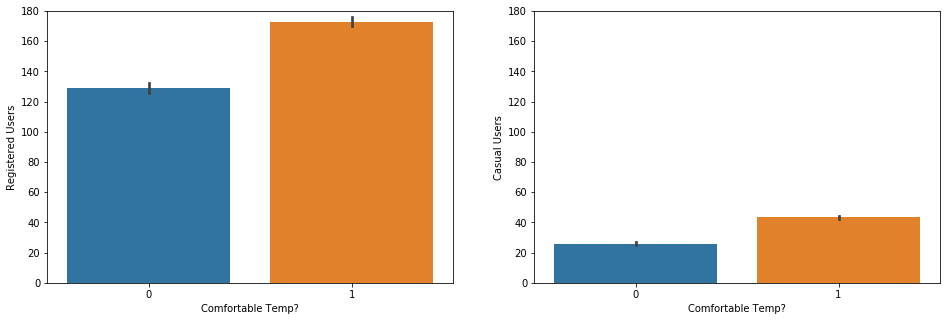

In [6]:
fig, ax = plt.subplots(1,2)
sns.barplot(data=df, x='Comfortable Temp?', y='Registered Users', ax=ax[0])
sns.barplot(data=df, x='Comfortable Temp?', y='Casual Users', ax=ax[1])
ax[0].set(ylim=(0, 180))
ax[1].set(ylim=(0, 180))
fig.set_figheight(5)
fig.set_figwidth(16)
plt.show()

In [7]:
comfy_registered = df[df['Comfortable Temp?'] == 1]['Registered Users']
noncomfy_registered = df[df['Comfortable Temp?'] == 0]['Registered Users']

In [8]:
scipy.stats.ttest_ind(comfy_registered, noncomfy_registered)

Ttest_indResult(statistic=19.141783708515234, pvalue=7.6926513295976845e-81)

With a p-value significantly lower than 0.05, we can conclude that these means are statistically different and that temperature does affect the level of registered ridership.

In [9]:
comfy_casual = df[df['Comfortable Temp?'] == 1]['Casual Users']
noncomfy_casual = df[df['Comfortable Temp?'] == 0]['Casual Users']

In [10]:
scipy.stats.ttest_ind(comfy_casual, noncomfy_casual)

Ttest_indResult(statistic=23.30627567580721, pvalue=2.4872749610746814e-118)

With a p-value significantly lower than 0.05, we can conclude that these means are statistically different and that temperature does affect the level of casual ridership.

### Does Weather Type affect ridership of registered users?

How much does a bad weather day affect that day's rides/revenue?

### Do more riders ride in the morning or evening? 

Do people bike into work but not out, or vice versa, what are the pain points driving this behavior?

### Are there more riders in 2011 or 2012?

Is our market share growing?

### Are there differences in monthly ridership? Between registered and casual?

### Percentage of rides that are rush hour commutes? 

Idea is to say, here is when you should ride for less congestion.

Looking at commutes 7-8am and 5-6pm.

In [53]:
df_7a = df[df.Hour == 7]
df_8a = df[df.Hour == 8]
df_5p = df[df.Hour == 17]
df_6p = df[df.Hour == 18]

In [54]:
df_commute = pd.concat([df_7a, df_8a, df_5p, df_6p])

In [55]:
commute_riders = df_commute['Total Users'].sum()

In [56]:
non_commute_riders = df['Total Users'].sum() - commute_riders

In [57]:
x = ['Commuter Rides', 'Non-Commuter Rides']
y = [commute_riders, non_commute_riders]

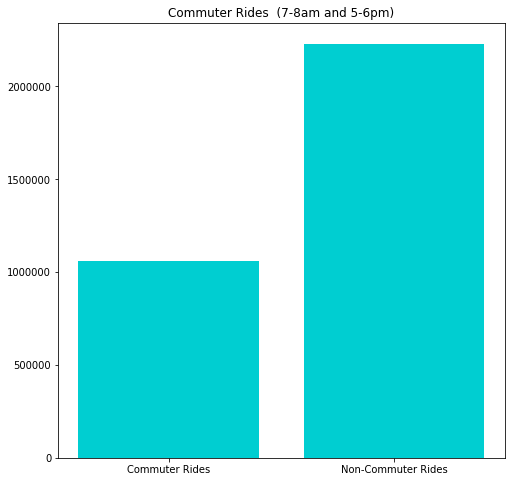

In [58]:
plt.figure(figsize=(8,8))
plt.bar(x, y, color ='darkturquoise')
plt.title('Commuter Rides  (7-8am and 5-6pm)')
plt.show()

If we open up the commuter hours by an hour on each side, 7-9am and 5-7pm.

In [59]:
df_7a = df[df.Hour == 7]
df_8a = df[df.Hour == 8]
df_9a = df[df.Hour == 9]
df_5p = df[df.Hour == 17]
df_6p = df[df.Hour == 18]
df_7p = df[df.Hour == 19]

In [60]:
df_commute = pd.concat([df_7a, df_8a, df_9a, df_5p, df_6p, df_7p])

In [61]:
commute_riders = df_commute['Total Users'].sum()

In [62]:
non_commute_riders = df['Total Users'].sum() - commute_riders

In [63]:
x = ['Commuter Rides', 'Non-Commuter Rides']
y = [commute_riders, non_commute_riders]

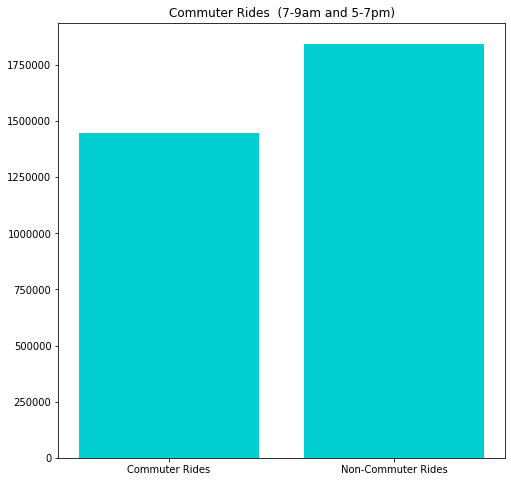

In [64]:
plt.figure(figsize=(8,8))
plt.bar(x, y, color ='darkturquoise')
plt.title('Commuter Rides  (7-9am and 5-7pm)')
plt.show()

In [65]:
commute_riders/(commute_riders + non_commute_riders)*100

43.97729022476834

Increasing the window of commuter times to 7-9am and 5-7pm shows that about 45% of total rides are commuters.

### Look into what is counted as a holiday here...

In [11]:
df[df.Holiday == 1]['Date'].value_counts()

2012-04-16    24
2012-07-04    24
2011-10-10    24
2012-05-28    24
2011-11-24    24
2011-04-15    24
2011-05-30    24
2012-01-16    24
2012-09-03    24
2012-11-12    24
2011-01-17    24
2011-09-05    24
2011-11-11    24
2011-07-04    24
2012-10-08    24
2012-11-22    24
2011-02-21    24
2011-12-26    23
2012-01-02    23
2012-12-25    23
2012-02-20    23
Name: Date, dtype: int64

- Martin Luther King, Jr. Day
- President's Day
- Easter
- Memorial Day
- Independence Day
- Labor Day
- Columbus Day
- Veterans' Day
- Thanksgiving
- Christmas
- New Years